## Решение задания от ABBYY (Шкунков Арсений)

В этом jupyter-ноутбуке содержится простое прокомментированное решение, с реализованными функциями predict() и predict_once().
Чтобы быстро все запустить и проверить работоспособность.

### План работы

Возьмем большой датасет Old Newspaper - https://www.kaggle.com/alvations/old-newspapers, выберем из него записи на 9-ти языках ('English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian', 'Korean', 'Turkish', 'Polish'). 
Далее сделаем выборку (по 30 тысяч записей на язык) и добавим еще 6 языков (суммарно: . Далее проведем предобработку (lowercase, токенизация), и воспользуемся TF-IFD. Обучим LogReg и kNN, сравним результаты. Напишем фукнции predict() и predict_once()

### Загрузка и обработка данных

In [1]:
import numpy as np
import pandas as pd

Во время работы на компьютере я использовал весь датасет old_newspaper.tsv, но так как он весит 6Gb, я не могу его полностью загрузить на GitHub.
Вместо него вы можете использовать его более легкую версию old_newspaper_light.csv из моего репозитория (тем не менее, код для его создания из исходного датасета есть в конце ноутбука), либо скачать оригинал по ссылке с Kaggle https://www.kaggle.com/alvations/old-newspapers
Далее я буду использовать облегченную версию

In [6]:
corpus = pd.read_csv('data/old_newspaper_light.csv')

Посмотрим на данные

In [7]:
corpus.head()

,Language,Text
0,Chinese (Traditional),方道生指，梁頌學的腦大靜脈由於受擠壓，之前有大約三分一的腦靜脈閉塞，問題嚴重，而菲國醫生用了...
1,Chinese (Traditional),關於「建材下鄉」在市場上已傳聞許久。從去年9月起，中國相關行業協會和組織就已經開始為「建材下...
2,Chinese (Traditional),報告說：“調查結果，令人非常失望。沒有一家企業能獲得最高的五星，近46%的企業處於零級。僅有...
3,Chinese (Traditional),女人唔易做，美人更不易為。保養完美無瑕的外貌很倦人，剛顧及對抗臉上皺紋，又說頸紋更加暴露年紀...
4,Chinese (Traditional),王奇說，由於很多人擔心課堂上就是用來分組玩牌，所以他只安排了非常少的實踐內容，大部分時間是講...


In [13]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Language  300000 non-null  object
 1   Text      300000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


### Преобработка данных, токенизация и TF-IDF

In [26]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

Посмотрим на общее количество строк для каждого языка.

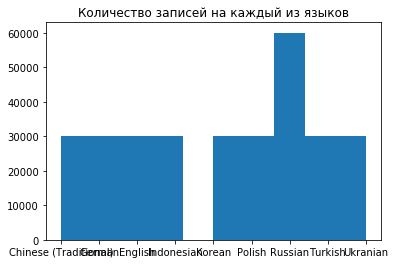

In [11]:
plt.hist(corpus['Language'])
plt.title('Количество записей на каждый из языков')
plt.show()

Обработаем данные. Уберем лишние знаки, приведем все к нижнему регистру и разобьем каждую строку на токены. Далее разметим строки по принципу: 1 - русский язык, 0 - другие языки.

In [14]:
import string

corpus['Text'] = corpus['Text'].replace(r'[{}]'.format(string.punctuation), '', regex=True)
corpus['Text'] = [text.lower() for text in corpus['Text']]
corpus['Text'] = [word_tokenize(text) for text in corpus['Text']]

In [15]:
corpus.reset_index(inplace=True)
corpus['Language'].value_counts()

Russian                  60000
Ukranian                 30000
Korean                   30000
English                  30000
Chinese (Traditional)    30000
German                   30000
Polish                   30000
Indonesian               30000
Turkish                  30000
Name: Language, dtype: int64

In [16]:
corpus.loc[corpus['Language'] == "Russian", "Language"] = 1
corpus.loc[corpus['Language'] != 1, "Language"] = 0

corpus.drop(corpus.columns[0], axis=1, inplace=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus = corpus.astype({"Text": str})

Разобьем обработанные данные на train и test и загрузим в TF-IDF-Vectorizer. Далее создадим модели логистической регрессии и kNN, и обучим их на векторах преобразованных с помощью TF-IDF

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corpus['Text'], corpus['Language'], test_size=0.3)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [18]:
Tfidf_vect = TfidfVectorizer(max_features=25000)
Tfidf_vect.fit(corpus['Text'])
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

In [23]:
model_logreg = LogisticRegression(random_state=42)
model_logreg.fit(X_train_Tfidf, y_train)

logreg_pred = model_logreg.predict(X_test_Tfidf)
logreg_pred = logreg_pred.astype('int')

Посчитаем метрики и выведем результат

In [27]:
print('Classification Report LogReg')
print(classification_report(y_test, logreg_pred))

print('Accuracy LogReg:', accuracy_score(y_test, logreg_pred))
print('F1-Score LogReg:', f1_score(y_test, logreg_pred))

Classification Report LogReg
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     71869
           1       1.00      0.93      0.96     18131

    accuracy                           0.98     90000
   macro avg       0.99      0.96      0.98     90000
weighted avg       0.98      0.98      0.98     90000

Accuracy LogReg: 0.9845
F1-Score LogReg: 0.9601599314579466


Из метрик видно, что результат у LogReg показывает очень хороший результат.


Напишем функции predict() и predict_once()

In [33]:
import os

def predict(path: str):
    # функция предсказания, path - путь к папке с текстами
    directory = os.listdir(path)
    directory = sorted(directory, key=lambda x: int(x[:-4]))
    predictions = []

    for file in directory:
        open_file = open(path + '/' + file, 'r+')
        read_file = open_file.read()
        answer = predict_once(read_file)
        predictions.append(answer)

    data_for_csv = {'File Name': directory, 'Predictions': predictions}
    results = pd.DataFrame(data=data_for_csv)
    results.to_csv('data/predictions_abbyy.csv', index=False)

In [41]:
def predict_once(text: str):
    # функция предсказания для входной строки
    cleaned_text = text.translate(str.maketrans('', '', string.punctuation))
    cleaned_text = cleaned_text.lower()
    tokenized_text = word_tokenize(cleaned_text)
    vector = Tfidf_vect.transform(tokenized_text)
    prediction = model_logreg.predict(vector)

    return max(prediction)

In [42]:
predict('data/data_abbyy')

### Код для создания более легкого датасета из оригинального.

In [2]:
corpus = pd.read_csv('data/old-newspaper.tsv', sep='\t', error_bad_lines=False)
corpus = corpus[corpus['Language'].isin(['English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian',
                                         'Korean', 'Turkish', 'Polish'])]

In [242]:
corpus.drop(corpus.columns[[1, 2]], axis=1, inplace=True)

size = 30000

languages = ['English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian',
             'Korean', 'Turkish', 'Polish']

def select_rows(corpus, language, size):
    if language == 'Russian': size = size * 2
    lang_arr = corpus[corpus['Language'] == language][0:size]
    lang_idx = corpus[corpus['Language'] == language].index
    corpus.drop(lang_idx, inplace=True)
    corpus = corpus.combine_first(lang_arr)
    
    return corpus
    
for lang in languages:
    corpus = select_rows(corpus, lang, size)

In [243]:
corpus.to_csv('data/old_newspaper_light.csv', index=False)